# Exercise 4: Unsupervised Learning

Extension of https://oist.github.io/BrainComputation/Unsupervised.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal

### 1. K-means and Mixtures of Gaussians

In [9]:
# X, y_true = make_blobs(n_samples=500, centers=3, cluster_std=0.8, random_state=42)
X, y_true = make_blobs(
    n_samples=500,
    centers=[[-1, -1], [1, 3], [3, 0]],
    cluster_std=[0.25, 0.35, 0.5],
    random_state=42
)
# add uniform noise
noise = np.random.RandomState(0).uniform(low=-6, high=6, size=(50, 2))
X = np.vstack((X, noise))

In [3]:
def kmeans(data, k, max_iter=20):
    n, d = data.shape
    # init centroids by sampling k points
    centroids = data[np.random.choice(n, k, replace=False)]
    labels = np.zeros(n, dtype=int)
    for i in range(max_iter):
        # assign step
        for j in range(n):
            dist = ((data[j] - centroids)**2).sum(axis=1)
            labels[j] = dist.argmin()
        # update step
        new_centroids = np.array([data[labels==c].mean(axis=0) for c in range(k)])
        if np.allclose(centroids, new_centroids):
            print('kmeans converged at iter', i)
            break
        centroids = new_centroids
    return labels, centroids

In [4]:
def gmm(data, k, max_iter=100, tol=1e-6):
    n, d = data.shape
    # init params - improved initialization
    means = data[np.random.choice(n, k, replace=False)]
    covs = np.repeat(np.cov(data, rowvar=False).reshape(1, d, d), k, axis=0)
    weights = np.ones(k) / k
    resp = np.zeros((n, k))
    
    for i in range(max_iter):
        # e-step: compute responsibilities
        for j in range(n):
            pdfs = np.array([multivariate_normal.pdf(data[j], means[c], covs[c])
                             for c in range(k)])
            mix = weights * pdfs
            resp[j] = mix / np.sum(mix)
        # m-step: update params
        n_k = np.sum(resp, axis=0)  # effective numbers for each cluster
        weights = n_k / n
        # update means
        new_means = np.zeros_like(means)
        for c in range(k):
            new_means[c] = np.sum(resp[:, c][:, None] * data, axis=0) / n_k[c]
        # update covariances with numerical stability
        new_covs = np.zeros_like(covs)
        for c in range(k):
            diff = data - new_means[c]
            new_covs[c] = (resp[:, c][:, None] * diff).T @ diff / n_k[c]
        # check convergence based on responsibility changes (more robust)
        if i > 0:
            resp_change = np.sum(np.abs(resp - prev_resp)) / n
            if resp_change < tol:
                print('gmm converged at iter', i)
                means, covs = new_means, new_covs
                break
        prev_resp = resp.copy()
        means, covs = new_means, new_covs
    
    return resp, means, covs, weights

In [5]:
def plot_clusters(data, labels, centers=None, title=''):
    plt.figure(figsize=(6,4))
    plt.scatter(data[:,0], data[:,1], c=labels, s=10)
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1],
                    marker='x', s=80, linewidths=2, c='red')
    plt.title(title)
    plt.tight_layout()
    plt.show()

kmeans converged at iter 6


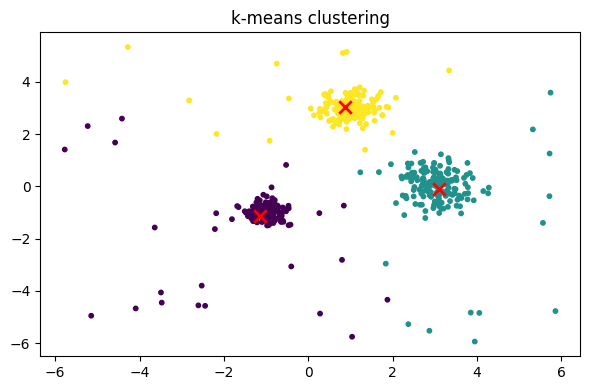

K-means centers: [[-1.13915436 -1.13404338]
 [ 3.09814991 -0.10437132]
 [ 0.87853516  3.02152367]]
gmm converged at iter 17


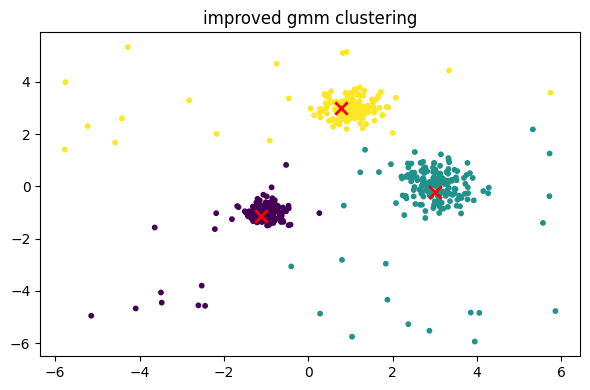

GMM means: [[-1.11645616 -1.12157426]
 [ 2.99587363 -0.21273963]
 [ 0.76570136  3.00902117]]
GMM weights: [0.32711427 0.33984537 0.33304036]


In [10]:
k_labels, k_centers = kmeans(X, 3)
plot_clusters(X, k_labels, k_centers, title='k-means clustering')
print("K-means centers:", k_centers)

# test GMM
resp, g_means, g_covs, g_weights = gmm(X, 3)
g_labels = resp.argmax(axis=1)
plot_clusters(X, g_labels, g_means, title='improved gmm clustering')
print("GMM means:", g_means)
print("GMM weights:", g_weights)

### 2. PCA and SVD on High-Dimensional Data

neural data shape: (10000, 100)
original components shape: (3, 50)
mixing matrix shape: (100, 3)


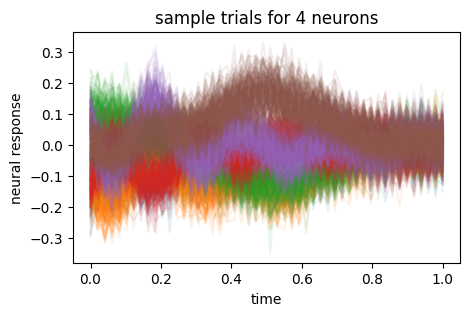

In [ ]:
# generate synthetic neural data using improved approach
np.random.seed(42)

n_neurons = 100
n_trials = 200 
n_timepoints = 50

# create temporal components
time = np.linspace(0, 1, n_timepoints)
comp1 = np.exp(-3 * time) # exponential decay
comp2 = np.exp(-20 * (time - 0.5)**2) # gaussian bump  
comp3 = np.sin(2 * np.pi * 4 * time) * np.exp(-2.5 * time) # damped oscillation
components = np.vstack([comp1, comp2, comp3]) # (3, T)

# create mixing matrix
rng = np.random.default_rng(42)
mixing_matrix = rng.normal(size=(n_neurons, 3))
mixing_matrix /= np.linalg.norm(mixing_matrix, axis=0, keepdims=True) + 1e-12  # column-normalize

# generate trial data with proper structure
trial_gains = 1.0 + 0.15 * rng.normal(size=(n_trials, 3))  # trial amplitude jitter
neural_data = np.zeros((n_trials, n_timepoints, n_neurons))

for trial in range(n_trials):
    # apply trial-specific scaling to components
    components_scaled = (trial_gains[trial, :, None]) * components  # (3, T)
    # mix components across neurons and add noise
    neural_data[trial] = (mixing_matrix @ components_scaled).T + 0.05 * rng.normal(size=(n_timepoints, n_neurons))

# reshape for analysis: (trials * timepoints, neurons)
x_neural = neural_data.reshape(-1, n_neurons)

print(f'neural data shape: {x_neural.shape}')
print(f'original components shape: {components.shape}')
print(f'mixing matrix shape: {mixing_matrix.shape}')

# plot noisy neural data for first few neurons
plt.figure(figsize=(5, 3))
for n, neuron in enumerate(np.random.choice(range(n_neurons), 6, replace=False)):
    for trial in range(n_trials):
        plt.plot(time, neural_data[trial, :, neuron], color=f'C{n}', alpha=0.1)
plt.title('sample trials for 4 neurons')
plt.xlabel('time')
plt.ylabel('neural response')
plt.show()

In [ ]:
def pca(data, n_components=3):
    # center the data
    data_centered = data - np.mean(data, axis=0)
    # compute covariance matrix
    cov_matrix = np.cov(data_centered, rowvar=False)
    # eigendecomposition
    eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)
    # sort by eigenvalues (descending)
    idx = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]
    # project data onto principal components
    pc_scores = data_centered @ eigenvecs[:, :n_components]
    return pc_scores, eigenvecs[:, :n_components], eigenvals[:n_components], data_centered

def align_components(recovered_components, true_components):
    """align recovered components with true components using correlation"""
    from scipy.optimize import linear_sum_assignment
    n_comp = true_components.shape[0]
    corr_matrix = np.zeros((n_comp, n_comp))
    
    for i in range(n_comp):
        for j in range(n_comp):
            # center both components for proper correlation
            rec_centered = recovered_components[i] - np.mean(recovered_components[i])
            true_centered = true_components[j] - np.mean(true_components[j])
            # compute absolute correlation
            denom = np.linalg.norm(rec_centered) * np.linalg.norm(true_centered) + 1e-12
            corr_matrix[i, j] = abs(np.dot(rec_centered, true_centered) / denom)
    
    # find optimal assignment using hungarian algorithm
    cost_matrix = -corr_matrix  # negative for maximization
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # determine signs for alignment
    signs = np.zeros(n_comp)
    correlations = np.zeros(n_comp)
    for i in range(n_comp):
        rec_idx, true_idx = row_indices[i], col_indices[i]
        # compute signed correlation
        rec_centered = recovered_components[rec_idx] - np.mean(recovered_components[rec_idx])
        true_centered = true_components[true_idx] - np.mean(true_components[true_idx])
        signed_corr = np.dot(rec_centered, true_centered) / (np.linalg.norm(rec_centered) * np.linalg.norm(true_centered) + 1e-12)
        signs[i] = np.sign(signed_corr)
        correlations[i] = abs(signed_corr)
    
    return row_indices, col_indices, signs, correlations

# apply improved pca to neural data
pc_scores_pca, pc_loadings_pca, eigenvals_pca, x_neural_centered = pca(x_neural, n_components=3)
print(f'pca scores shape: {pc_scores_pca.shape}')
print(f'explained variance ratios: {eigenvals_pca / np.sum(eigenvals_pca)}')

pca scores shape: (10000, 3)
explained variance ratios: [0.44672899 0.37191031 0.1813607 ]


In [94]:
def svd_decomp(data, n_components=3):
    # center the data (critical for proper component recovery)
    data_centered = data - np.mean(data, axis=0)
    # svd decomposition
    u, s, vt = np.linalg.svd(data_centered, full_matrices=False)
    # project data onto first n components
    pc_scores = u[:, :n_components] * s[:n_components]
    # loadings are the right singular vectors
    pc_loadings = vt[:n_components].T
    # eigenvalues from singular values
    eigenvals = (s[:n_components] ** 2) / (data.shape[0] - 1)
    return pc_scores, pc_loadings, eigenvals, data_centered

# apply svd to neural data with proper centering
pc_scores_svd, pc_loadings_svd, eigenvals_svd, x_neural_centered_svd = svd_decomp(x_neural, n_components=3)
print(f'svd scores shape: {pc_scores_svd.shape}')
print(f'explained variance ratios: {eigenvals_svd / np.sum(eigenvals_svd)}')

svd scores shape: (10000, 3)
explained variance ratios: [0.44672899 0.37191031 0.1813607 ]


eigenvector shapes (loadings): (100, 3)
pc scores shape: (10000, 3)


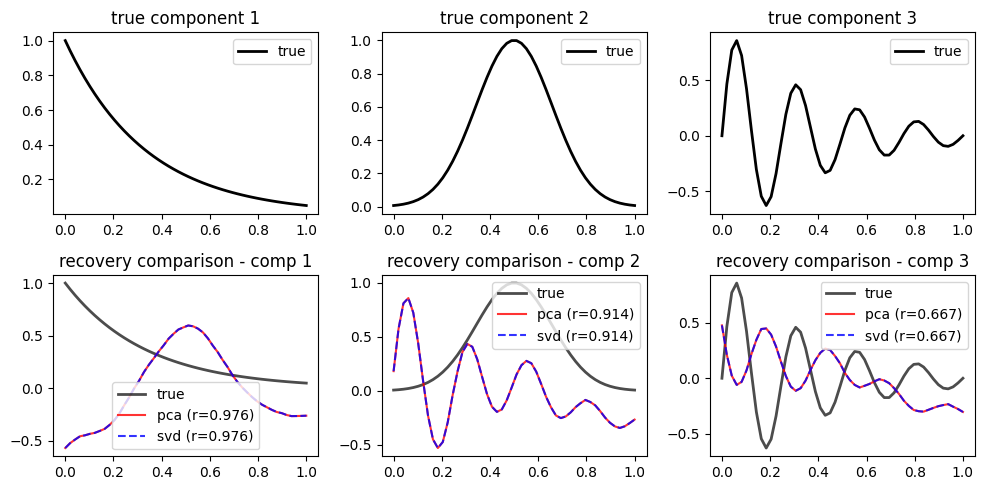

recovery quality (correlations with true components):
pca: [0.97566902 0.91369021 0.66678235] (avg: 0.852)
svd: [0.97566902 0.91369021 0.66678235] (avg: 0.852)

spatial pattern analysis (mixing recovery):
true mixing matrix shape: (100, 3)
pca loadings (spatial patterns) shape: (100, 3)
mixing pattern correlations: [0.92575951 0.88168663 0.8206469 ] (avg: 0.876)

the loadings reveal which neurons contribute to each recovered temporal component
higher correlations indicate better recovery of the original neuron-component relationships


In [107]:
# compare pca and svd results with proper alignment and correlation analysis
print(f'eigenvector shapes (loadings): {pc_loadings_pca.shape}')  # (100, 3) - spatial patterns
print(f'pc scores shape: {pc_scores_pca.shape}')  # (10000, 3) - temporal projections

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

# plot true temporal components that went into mixing
for i in range(3):
    axes[0, i].plot(time, components[i], 'k-', linewidth=2, label='true')
    axes[0, i].set_title(f'true component {i+1}')
    axes[0, i].legend()

# recover temporal components by reshaping pc scores back to trial structure
pca_reshaped = pc_scores_pca.reshape(n_trials, n_timepoints, 3)
svd_reshaped = pc_scores_svd.reshape(n_trials, n_timepoints, 3)

# average across trials to get recovered temporal components
pca_avg = pca_reshaped.mean(axis=0).T  # (3, T) - average temporal patterns
svd_avg = svd_reshaped.mean(axis=0).T

# align components using correlation matching
pca_row_ind, pca_col_ind, pca_signs, pca_corrs = align_components(pca_avg, components)
svd_row_ind, svd_col_ind, svd_signs, svd_corrs = align_components(svd_avg, components)

# plot overlapping recovered components (PCA and SVD together)
for i in range(3):
    pca_comp = pca_avg[pca_row_ind[i]] * pca_signs[i]
    svd_comp = svd_avg[svd_row_ind[i]] * svd_signs[i]
    
    axes[1, i].plot(time, components[i], 'k-', linewidth=2, alpha=0.7, label='true')
    axes[1, i].plot(time, pca_comp, 'r-', label=f'pca (r={pca_corrs[i]:.3f})', alpha=0.8)
    axes[1, i].plot(time, svd_comp, 'b--', label=f'svd (r={svd_corrs[i]:.3f})', alpha=0.8)
    axes[1, i].set_title(f'recovery comparison - comp {i+1}')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

print('recovery quality (correlations with true components):')
print(f'pca: {pca_corrs} (avg: {np.mean(pca_corrs):.3f})')
print(f'svd: {svd_corrs} (avg: {np.mean(svd_corrs):.3f})')

# analyze mixing matrix recovery through loadings
print('\nspatial pattern analysis (mixing recovery):')
print(f'true mixing matrix shape: {mixing_matrix.shape}')
print(f'pca loadings (spatial patterns) shape: {pc_loadings_pca.shape}')

# compare spatial patterns - loadings show how neurons contribute to each component
mixing_corrs = np.zeros(3)
for i in range(3):
    # correlate pca loadings with true mixing patterns
    true_pattern = mixing_matrix[:, pca_col_ind[i]]  # matched true mixing column
    pca_pattern = pc_loadings_pca[:, pca_row_ind[i]] * pca_signs[i]  # aligned pca loading
    mixing_corrs[i] = abs(np.corrcoef(true_pattern, pca_pattern)[0,1])

print(f'mixing pattern correlations: {mixing_corrs} (avg: {np.mean(mixing_corrs):.3f})')
print('\nthe loadings reveal which neurons contribute to each recovered temporal component')
print('higher correlations indicate better recovery of the original neuron-component relationships')

### 3. ICA on High-Dimensional Data

In [108]:
from sklearn.decomposition import FastICA

def ica(X, W=None, alpha=0.01, online=True):
    """ica by max entropy with tanh() nonlinearity"""
    N, D = X.shape
    if W is None:
        W = np.eye(D)
    if online:
        for n in range(N):
            u = W@X[n,:]  
            y = np.tanh(u)
            W += alpha*(W - np.outer(y,u@W))
    else:  # batch update
        U = X@W.T
        Y = np.tanh(U)
        W += alpha*(W - Y.T@U@W/N)
    return W

# apply ica to unmix neural responses and recover temporal components
x_centered = x_neural_centered  # use the centered data from PCA

# custom ica implementation with multiple iterations for convergence
W_custom = np.eye(x_centered.shape[1])
for k in range(50):  # increased iterations for better convergence
    W_custom = ica(x_centered, W_custom, alpha=0.001, online=True)

# get the unmixed components (all components first, then select best 3)
ic_scores_custom_all = x_centered @ W_custom.T

# sklearn fastica - directly specify 3 components to match our true components
# use proper initialization and parameters for better convergence
fastica = FastICA(n_components=3, random_state=42, max_iter=2000, tol=1e-6)
ic_scores_sklearn = fastica.fit_transform(x_centered)
W_sklearn = fastica.components_  # unmixing matrix
A_sklearn = fastica.mixing_     # mixing matrix estimate

print(f'neural data shape: {x_centered.shape}')
print(f'custom ica unmixing matrix shape: {W_custom.shape}')
print(f'sklearn ica unmixing matrix shape: {W_sklearn.shape}')
print(f'sklearn ica mixing matrix estimate shape: {A_sklearn.shape}')
print(f'true mixing matrix shape: {mixing_matrix.shape}')
print(f'recovered components shape: custom={ic_scores_custom_all.shape}, sklearn={ic_scores_sklearn.shape}')

neural data shape: (10000, 100)
custom ica unmixing matrix shape: (100, 100)
sklearn ica unmixing matrix shape: (3, 100)
sklearn ica mixing matrix estimate shape: (100, 3)
true mixing matrix shape: (100, 3)
recovered components shape: custom=(10000, 100), sklearn=(10000, 3)


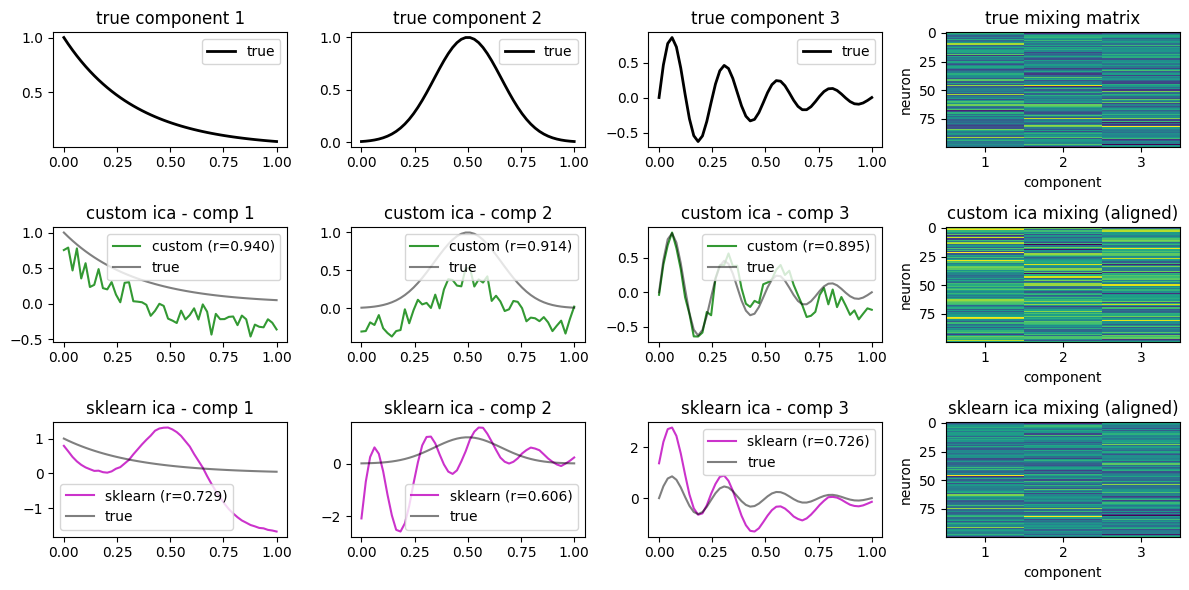

temporal component recovery (correlations with true):
custom ica:  [0.94018942 0.9144293  0.89485134] (avg: 0.916)
sklearn ica: [0.7289649  0.60574085 0.72603192] (avg: 0.687)

mixing matrix recovery (spatial pattern correlations):
custom ica:  [0.04092954 0.022561   0.03634551] (avg: 0.033)
sklearn ica: [0.9019559  0.72688298 0.55761013] (avg: 0.729)

best custom components selected from positions: [16 40 78]


In [113]:
# comprehensive ica analysis with component alignment and mixing matrix comparison
fig, axes = plt.subplots(3, 4, figsize=(12, 6))

# plot true temporal components
for i in range(3):
    axes[0, i].plot(time, components[i], 'k-', linewidth=2, label='true')
    axes[0, i].set_title(f'true component {i+1}')
    axes[0, i].legend()

# for custom ICA, first find the best 3 components by correlation with true components
ic_custom_reshaped_all = ic_scores_custom_all.reshape(n_trials, n_timepoints, -1)
ic_custom_avg_all = ic_custom_reshaped_all.mean(axis=0).T  # (100, T)

# find best 3 components from custom ICA
max_corrs = np.zeros(100)
for comp_idx in range(100):
    comp_corrs = []
    for true_idx in range(3):
        comp_centered = ic_custom_avg_all[comp_idx] - np.mean(ic_custom_avg_all[comp_idx])
        true_centered = components[true_idx] - np.mean(components[true_idx])
        denom = np.linalg.norm(comp_centered) * np.linalg.norm(true_centered) + 1e-12
        comp_corrs.append(abs(np.dot(comp_centered, true_centered) / denom))
    max_corrs[comp_idx] = max(comp_corrs)

# select top 3 components with highest correlations
best_custom_indices = np.argsort(max_corrs)[-3:][::-1]
ic_custom_avg_best = ic_custom_avg_all[best_custom_indices]  # (3, T)

# reshape sklearn results
ic_sklearn_reshaped = ic_scores_sklearn.reshape(n_trials, n_timepoints, 3)
ic_sklearn_avg = ic_sklearn_reshaped.mean(axis=0).T  # (3, T)

# align both methods with true components
custom_row_ind, custom_col_ind, custom_signs, custom_corrs = align_components(ic_custom_avg_best, components)
sklearn_row_ind, sklearn_col_ind, sklearn_signs, sklearn_corrs = align_components(ic_sklearn_avg, components)

# plot aligned recovered components
for i in range(3):
    # custom ICA
    custom_comp = ic_custom_avg_best[custom_row_ind[i]] * custom_signs[i]
    axes[1, i].plot(time, custom_comp, 'g-', label=f'custom (r={custom_corrs[i]:.3f})', alpha=0.8)
    axes[1, i].plot(time, components[i], 'k-', alpha=0.5, label='true')
    axes[1, i].set_title(f'custom ica - comp {i+1}')
    axes[1, i].legend()
    
    # sklearn ICA
    sklearn_comp = ic_sklearn_avg[sklearn_row_ind[i]] * sklearn_signs[i]
    axes[2, i].plot(time, sklearn_comp, 'm-', label=f'sklearn (r={sklearn_corrs[i]:.3f})', alpha=0.8)
    axes[2, i].plot(time, components[i], 'k-', alpha=0.5, label='true')
    axes[2, i].set_title(f'sklearn ica - comp {i+1}')
    axes[2, i].legend()

# mixing matrix visualization
def normalize_mixing(A):
    return A / (np.linalg.norm(A, axis=0, keepdims=True) + 1e-12)

# true mixing matrix
ax_mix = axes[0, 3]
im_true = ax_mix.imshow(normalize_mixing(mixing_matrix), aspect='auto', interpolation='nearest')
ax_mix.set_title('true mixing matrix')
ax_mix.set_xlabel('component')
ax_mix.set_ylabel('neuron')
ax_mix.set_xticks([0, 1, 2])
ax_mix.set_xticklabels(['1', '2', '3'])

# custom ICA mixing matrix (pseudo-inverse of unmixing matrix)
W_custom_best = W_custom[best_custom_indices, :]  # select best 3 rows
A_custom_est = np.linalg.pinv(W_custom_best)  # mixing matrix estimate
# normalize custom ICA mixing matrix the same way as true mixing matrix (column-normalize)
A_custom_est /= np.linalg.norm(A_custom_est, axis=0, keepdims=True) + 1e-12  # column-normalize like true mixing
A_custom_aligned = A_custom_est[:, custom_row_ind] * custom_signs[None, :]

ax_custom_mix = axes[1, 3]
im_custom = ax_custom_mix.imshow(normalize_mixing(A_custom_aligned), aspect='auto', interpolation='nearest')
ax_custom_mix.set_title('custom ica mixing (aligned)')
ax_custom_mix.set_xlabel('component')
ax_custom_mix.set_ylabel('neuron')
ax_custom_mix.set_xticks([0, 1, 2])
ax_custom_mix.set_xticklabels(['1', '2', '3'])

# sklearn ICA mixing matrix
A_sklearn_aligned = A_sklearn[:, sklearn_row_ind] * sklearn_signs[None, :]
ax_sklearn_mix = axes[2, 3]
im_sklearn = ax_sklearn_mix.imshow(normalize_mixing(A_sklearn_aligned), aspect='auto', interpolation='nearest')
ax_sklearn_mix.set_title('sklearn ica mixing (aligned)')
ax_sklearn_mix.set_xlabel('component')
ax_sklearn_mix.set_ylabel('neuron')
ax_sklearn_mix.set_xticks([0, 1, 2])
ax_sklearn_mix.set_xticklabels(['1', '2', '3'])

plt.tight_layout()
plt.show()

# compute mixing matrix correlations for both methods
custom_mixing_corrs = np.zeros(3)
sklearn_mixing_corrs = np.zeros(3)
A_true_norm = normalize_mixing(mixing_matrix)
A_custom_norm = normalize_mixing(A_custom_aligned)
A_sklearn_norm = normalize_mixing(A_sklearn_aligned)

for i in range(3):
    true_pattern = A_true_norm[:, custom_col_ind[i]]
    custom_pattern = A_custom_norm[:, i]
    custom_mixing_corrs[i] = abs(np.corrcoef(true_pattern, custom_pattern)[0,1])
    
    true_pattern = A_true_norm[:, sklearn_col_ind[i]]
    sklearn_pattern = A_sklearn_norm[:, i]
    sklearn_mixing_corrs[i] = abs(np.corrcoef(true_pattern, sklearn_pattern)[0,1])

# comprehensive results summary
print('temporal component recovery (correlations with true):')
print(f'custom ica:  {custom_corrs} (avg: {np.mean(custom_corrs):.3f})')
print(f'sklearn ica: {sklearn_corrs} (avg: {np.mean(sklearn_corrs):.3f})')

print('\nmixing matrix recovery (spatial pattern correlations):')
print(f'custom ica:  {custom_mixing_corrs} (avg: {np.mean(custom_mixing_corrs):.3f})')
print(f'sklearn ica: {sklearn_mixing_corrs} (avg: {np.mean(sklearn_mixing_corrs):.3f})')

print(f'\nbest custom components selected from positions: {best_custom_indices}')